In [ ]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout,RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import pandas as pd
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, RocCurveDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fp ='dataset_1'
filepath= f'drive/MyDrive/{fp}'
shutil.copytree(filepath,fp)
shutil.copy('drive/MyDrive/Capstone/Code/cnn_utils.py','cnn_utils.py')
from cnn_utils import *

In [ ]:
!nvidia-smi

Thu May 12 23:17:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    34W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
      ]

In [ ]:
def run_model(epochs,model_run,lr,batch_size,model,stopping_patience=1):
    if not os.path.exists('drive/MyDrive/model_checkpoints'):
      os.mkdir('drive/MyDrive/model_checkpoints')

    outpath = os.path.join('drive/MyDrive/model_checkpoints',model_run)
    if not os.path.exists(outpath):
      os.mkdir(outpath)
    callbacks = [EarlyStopping(patience = stopping_patience,restore_best_weights=True),
                 ModelCheckpoint(outpath,save_best_only=True,verbose=False)]



    AUTOTUNE = tf.data.AUTOTUNE
    batch_size= 32
    training, val = load_data(fp,batch_size)
    training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val.cache().prefetch(buffer_size=AUTOTUNE)
    
    opt=Adam(learning_rate=lr)
    model.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics=metrics)
    
    history = model.fit(training, validation_data=val,epochs=epochs,callbacks = callbacks)
    
    test_preds, test_labels = get_predictions(model,val)
    plot_confusion_matrix(test_preds, test_labels)
    plt.show()
    plot_confusion_matrix(test_preds, test_labels,p=0.95)
    plt.show()
    return history


def show_image_grid(images,title,size=(2,2)):
  images = images.astype(int)
  fig = plt.figure(figsize=(8,8))
  grid = ImageGrid(fig, "111", size)
  for ax, x in zip(grid,images):
    ax.imshow(x)
  
  fig.suptitle(title,fontsize=28,y=1.0)
  plt.show()

def show_performance(data,model,p=0.5,gridsize=3):
  data=data.shuffle(1000).as_numpy_iterator()
  features, labels = next(data)
  features = features.astype(int)

  logits=model.predict(features)
  preds=logits>p
  preds=np.ravel(preds)

  fp = np.logical_and(preds !=labels, preds)
  fp_imgs = features[np.where(fp)]

  fn = np.logical_and(preds!=labels, np.logical_not(preds))
  fn_imgs = features[np.where(fn)]

  tp_g = np.logical_and(preds==labels,preds)
  tp_g_imgs = features[np.where(tp_g)]

  tp_h =np.logical_and(preds==labels, np.logical_not(preds))
  tp_h_imgs = features[np.where(tp_h)]
  
  while any([not(len(i) >=gridsize**2) for i in [tp_g_imgs,tp_h_imgs,fn_imgs,fp_imgs]]):
    
    features, labels = next(data)
    features = features.astype(int)

    logits=model.predict(features)
    preds=logits>p
    preds=np.ravel(preds)

    fp = np.logical_and(preds !=labels, preds)
    fp_imgs = np.concatenate([features[np.where(fp)],fp_imgs])

    fn = np.logical_and(preds!=labels, np.logical_not(preds))
    fn_imgs = np.concatenate([features[np.where(fn)],fn_imgs])

    tp_g = np.logical_and(preds==labels,preds)
    tp_g_imgs =np.concatenate([features[np.where(tp_g)],tp_g_imgs])

    tp_h =np.logical_and(preds==labels, np.logical_not(preds))
    tp_h_imgs =np.concatenate([features[np.where(tp_h)],tp_h_imgs])
  

 

  show_image_grid(fp_imgs,f'False positive images @p={p}',size=(gridsize,gridsize))
  print('\n'*4)
  show_image_grid(fn_imgs,f'False negative images @p={p}',size=(gridsize,gridsize))
  print('\n'*4)
  show_image_grid(tp_g_imgs,f'True positive images \nidentifying weapon holder @p={p}',size=(gridsize,gridsize))
  print('\n'*4)
  show_image_grid(tp_h_imgs,f'True positive images \nidentifying non weapon holder @p={p}',size=(gridsize,gridsize))




Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_16 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_17 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                     

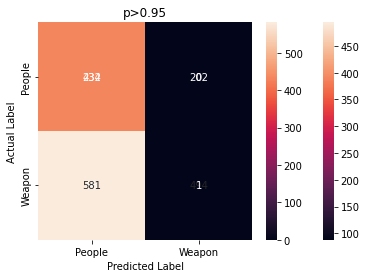

In [ ]:
epochs = 10
model_run = '7_run1'
lr = 0.001
batch_size= 32 


cnn = models.Sequential([layers.Rescaling(1./255,
                                           input_shape=(256,256,3))])
cnn.add(augment())
cnn = conv_block(cnn,64,dropout=0.2,batchnorm=True)
cnn=conv_block(cnn,128,dropout=0.4,batchnorm=True)
cnn=conv_block(cnn,256,depth=4,dropout=0.4,batchnorm=True)
cnn.add(layers.Flatten())
cnn.add(layers.Dense(256,activation='relu'))
cnn.add(layers.Dense(1,activation='sigmoid'))

#cnn.summary()

run_model(epochs,model_run,lr,batch_size,cnn)

#### Try larger batchsize

Found 5082 files belonging to 2 classes.
Using 4066 files for training.
Found 5082 files belonging to 2 classes.
Using 1016 files for validation.
Epoch 1/10
128/128 [==============================] - 52s 379ms/step - loss: 7.2783 - tp: 1465.0000 - fp: 875.0000 - tn: 1389.0000 - fn: 1353.0000 - accuracy: 0.5616 - precision: 0.6261 - recall: 0.5199 - auc: 0.5677 - prc: 0.6061 - val_loss: 35.2440 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_tn: 432.0000 - val_fn: 582.0000 - val_accuracy: 0.4252 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4884 - val_prc: 0.5522
Epoch 2/10
128/128 [==============================] - 49s 384ms/step - loss: 0.6599 - tp: 1610.0000 - fp: 766.0000 - tn: 1064.0000 - fn: 626.0000 - accuracy: 0.6576 - precision: 0.6776 - recall: 0.7200 - auc: 0.7060 - prc: 0.7194 - val_loss: 7.4598 - val_tp: 27.0000 - val_fp: 19.0000 - val_tn: 415.0000 - val_fn: 555.0000 - val_accuracy: 0.4350 - val_precision: 0.5870 - val_recall: 0.0464 - val_auc: 0.5063 - val_

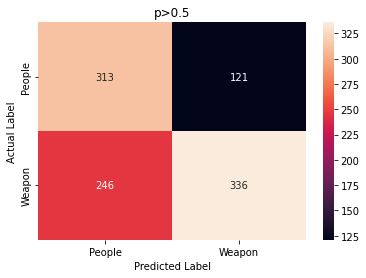

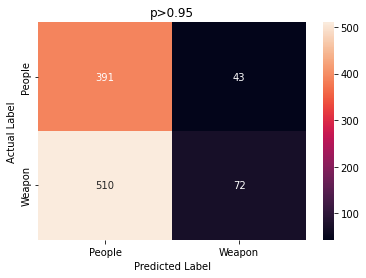

In [ ]:
epochs = 10
model_run = '7_run2'
lr = 0.001
batch_size= 64


cnn = models.Sequential([layers.Rescaling(1./255,
                                           input_shape=(256,256,3))])
cnn.add(augment())
cnn = conv_block(cnn,64,dropout=0.2,batchnorm=True)
cnn=conv_block(cnn,128,dropout=0.4,batchnorm=True)
cnn=conv_block(cnn,256,depth=4,dropout=0.4,batchnorm=True)
cnn.add(layers.Flatten())
cnn.add(layers.Dense(256,activation='relu'))
cnn.add(layers.Dense(1,activation='sigmoid'))
history= run_model(epochs,model_run,lr,batch_size,cnn)

In [ ]:
training, val = load_data(fp,batch_size)


Found 5082 files belonging to 2 classes.
Using 4066 files for training.
Found 5082 files belonging to 2 classes.
Using 1016 files for validation.


In [ ]:
show_performance(training,cnn,p=0.65)

## Try transfer learning

In [ ]:
from tensorflow.keras.applications import Xception 
from tensorflow.keras.applications.xception import preprocess_input

In [ ]:
base_model = Xception(weights='imagenet',
         input_shape=(256,256,3),
         include_top=False)
base_model.trainable = False #freeze base model layers
aug =augment()
inputs = keras.Input(shape=(256,256,3))
x = aug(inputs)
#scale=layers.Rescaling(1./127.5, offset = -1)
x=preprocess_input(x)
x=base_model(x,training=False)
x= keras.layers.GlobalAveragePooling2D()(x)
x= Dropout(0.2)(x)
outputs = Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_23 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_11  (None, 2048)             0   

In [ ]:
epochs = 100
model_run = '7_run3'
lr = 0.001
batch_size= 32

if not os.path.exists('drive/MyDrive/model_checkpoints'):
  os.mkdir('drive/MyDrive/model_checkpoints')

outpath = os.path.join('drive/MyDrive/model_checkpoints',model_run)
if not os.path.exists(outpath):
  os.mkdir(outpath)

callbacks = [EarlyStopping(patience = 2,restore_best_weights=True),
              ModelCheckpoint(outpath,save_best_only=True,verbose=False)]



AUTOTUNE = tf.data.AUTOTUNE
batch_size= 32
training, val = load_data(fp,batch_size)
training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val.cache().prefetch(buffer_size=AUTOTUNE)
    
opt=Adam(learning_rate=lr)
model.summary()
model.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics=metrics)

history = model.fit(training, validation_data=val,epochs=epochs,callbacks = callbacks)






Found 5082 files belonging to 2 classes.
Using 4066 files for training.
Found 5082 files belonging to 2 classes.
Using 1016 files for validation.
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_23 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 8, 204

INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


128/128 [==============================] - 43s 282ms/step - loss: 0.1683 - tp: 2639.0000 - fp: 157.0000 - tn: 2107.0000 - fn: 179.0000 - accuracy: 0.9339 - precision: 0.9438 - recall: 0.9365 - auc: 0.9823 - prc: 0.9861 - val_loss: 0.1726 - val_tp: 545.0000 - val_fp: 32.0000 - val_tn: 402.0000 - val_fn: 37.0000 - val_accuracy: 0.9321 - val_precision: 0.9445 - val_recall: 0.9364 - val_auc: 0.9807 - val_prc: 0.9850
Epoch 2/100
128/128 [==============================] - 18s 139ms/step - loss: 0.1706 - tp: 2087.0000 - fp: 126.0000 - tn: 1704.0000 - fn: 149.0000 - accuracy: 0.9324 - precision: 0.9431 - recall: 0.9334 - auc: 0.9823 - prc: 0.9856 - val_loss: 0.1759 - val_tp: 534.0000 - val_fp: 22.0000 - val_tn: 412.0000 - val_fn: 48.0000 - val_accuracy: 0.9311 - val_precision: 0.9604 - val_recall: 0.9175 - val_auc: 0.9814 - val_prc: 0.9869
Epoch 3/100
127/128 [============================>.] - ETA: 0s - loss: 0.1585 - tp: 2095.0000 - fp: 110.0000 - tn: 1719.0000 - fn: 140.0000 - accuracy: 0.93

INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


128/128 [==============================] - 33s 259ms/step - loss: 0.1585 - tp: 2096.0000 - fp: 110.0000 - tn: 1720.0000 - fn: 140.0000 - accuracy: 0.9385 - precision: 0.9501 - recall: 0.9374 - auc: 0.9847 - prc: 0.9883 - val_loss: 0.1674 - val_tp: 547.0000 - val_fp: 29.0000 - val_tn: 405.0000 - val_fn: 35.0000 - val_accuracy: 0.9370 - val_precision: 0.9497 - val_recall: 0.9399 - val_auc: 0.9819 - val_prc: 0.9858
Epoch 4/100
127/128 [============================>.] - ETA: 0s - loss: 0.1589 - tp: 2097.0000 - fp: 111.0000 - tn: 1719.0000 - fn: 137.0000 - accuracy: 0.9390 - precision: 0.9497 - recall: 0.9387 - auc: 0.9848 - prc: 0.9884

INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


128/128 [==============================] - 34s 268ms/step - loss: 0.1588 - tp: 2099.0000 - fp: 111.0000 - tn: 1719.0000 - fn: 137.0000 - accuracy: 0.9390 - precision: 0.9498 - recall: 0.9387 - auc: 0.9848 - prc: 0.9884 - val_loss: 0.1654 - val_tp: 545.0000 - val_fp: 28.0000 - val_tn: 406.0000 - val_fn: 37.0000 - val_accuracy: 0.9360 - val_precision: 0.9511 - val_recall: 0.9364 - val_auc: 0.9820 - val_prc: 0.9861
Epoch 5/100
127/128 [============================>.] - ETA: 0s - loss: 0.1489 - tp: 2118.0000 - fp: 114.0000 - tn: 1715.0000 - fn: 117.0000 - accuracy: 0.9432 - precision: 0.9489 - recall: 0.9477 - auc: 0.9870 - prc: 0.9899

INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


128/128 [==============================] - 34s 264ms/step - loss: 0.1488 - tp: 2119.0000 - fp: 114.0000 - tn: 1716.0000 - fn: 117.0000 - accuracy: 0.9432 - precision: 0.9489 - recall: 0.9477 - auc: 0.9870 - prc: 0.9899 - val_loss: 0.1636 - val_tp: 553.0000 - val_fp: 32.0000 - val_tn: 402.0000 - val_fn: 29.0000 - val_accuracy: 0.9400 - val_precision: 0.9453 - val_recall: 0.9502 - val_auc: 0.9829 - val_prc: 0.9867
Epoch 6/100
128/128 [==============================] - 18s 138ms/step - loss: 0.1514 - tp: 2106.0000 - fp: 118.0000 - tn: 1712.0000 - fn: 130.0000 - accuracy: 0.9390 - precision: 0.9469 - recall: 0.9419 - auc: 0.9860 - prc: 0.9888 - val_loss: 0.1656 - val_tp: 544.0000 - val_fp: 24.0000 - val_tn: 410.0000 - val_fn: 38.0000 - val_accuracy: 0.9390 - val_precision: 0.9577 - val_recall: 0.9347 - val_auc: 0.9823 - val_prc: 0.9863
Epoch 7/100
127/128 [============================>.] - ETA: 0s - loss: 0.1531 - tp: 2099.0000 - fp: 120.0000 - tn: 1709.0000 - fn: 136.0000 - accuracy: 0.93

INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


128/128 [==============================] - 34s 265ms/step - loss: 0.1531 - tp: 2100.0000 - fp: 120.0000 - tn: 1710.0000 - fn: 136.0000 - accuracy: 0.9370 - precision: 0.9459 - recall: 0.9392 - auc: 0.9857 - prc: 0.9888 - val_loss: 0.1628 - val_tp: 547.0000 - val_fp: 26.0000 - val_tn: 408.0000 - val_fn: 35.0000 - val_accuracy: 0.9400 - val_precision: 0.9546 - val_recall: 0.9399 - val_auc: 0.9825 - val_prc: 0.9866
Epoch 8/100
127/128 [============================>.] - ETA: 0s - loss: 0.1507 - tp: 2113.0000 - fp: 109.0000 - tn: 1720.0000 - fn: 122.0000 - accuracy: 0.9432 - precision: 0.9509 - recall: 0.9454 - auc: 0.9862 - prc: 0.9893

INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


128/128 [==============================] - 34s 268ms/step - loss: 0.1507 - tp: 2114.0000 - fp: 109.0000 - tn: 1721.0000 - fn: 122.0000 - accuracy: 0.9432 - precision: 0.9510 - recall: 0.9454 - auc: 0.9862 - prc: 0.9893 - val_loss: 0.1609 - val_tp: 551.0000 - val_fp: 30.0000 - val_tn: 404.0000 - val_fn: 31.0000 - val_accuracy: 0.9400 - val_precision: 0.9484 - val_recall: 0.9467 - val_auc: 0.9831 - val_prc: 0.9871
Epoch 9/100
127/128 [============================>.] - ETA: 0s - loss: 0.1499 - tp: 2109.0000 - fp: 113.0000 - tn: 1715.0000 - fn: 127.0000 - accuracy: 0.9409 - precision: 0.9491 - recall: 0.9432 - auc: 0.9864 - prc: 0.9893

INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_checkpoints/7_run3/assets


128/128 [==============================] - 33s 257ms/step - loss: 0.1498 - tp: 2109.0000 - fp: 113.0000 - tn: 1717.0000 - fn: 127.0000 - accuracy: 0.9410 - precision: 0.9491 - recall: 0.9432 - auc: 0.9864 - prc: 0.9893 - val_loss: 0.1591 - val_tp: 552.0000 - val_fp: 27.0000 - val_tn: 407.0000 - val_fn: 30.0000 - val_accuracy: 0.9439 - val_precision: 0.9534 - val_recall: 0.9485 - val_auc: 0.9834 - val_prc: 0.9873
Epoch 10/100
128/128 [==============================] - 18s 140ms/step - loss: 0.1533 - tp: 2095.0000 - fp: 111.0000 - tn: 1719.0000 - fn: 141.0000 - accuracy: 0.9380 - precision: 0.9497 - recall: 0.9369 - auc: 0.9854 - prc: 0.9882 - val_loss: 0.1609 - val_tp: 544.0000 - val_fp: 23.0000 - val_tn: 411.0000 - val_fn: 38.0000 - val_accuracy: 0.9400 - val_precision: 0.9594 - val_recall: 0.9347 - val_auc: 0.9831 - val_prc: 0.9871
Epoch 11/100
128/128 [==============================] - 18s 140ms/step - loss: 0.1382 - tp: 2116.0000 - fp: 104.0000 - tn: 1726.0000 - fn: 120.0000 - accur

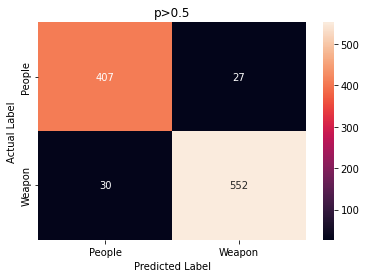

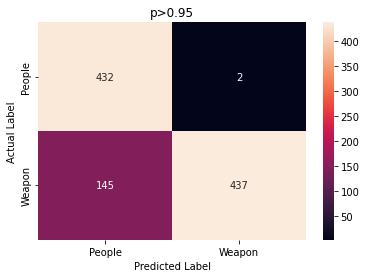

In [ ]:
test_preds, test_labels = get_predictions(model,val)
plot_confusion_matrix(test_preds, test_labels)
plt.show()
plot_confusion_matrix(test_preds, test_labels,p=0.95)
plt.show()



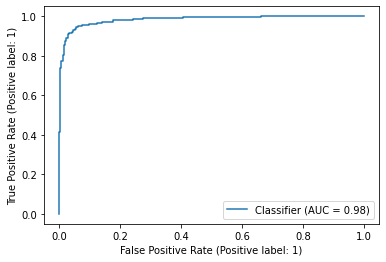

In [ ]:
RocCurveDisplay.from_predictions(test_labels,test_preds)
plt.show()

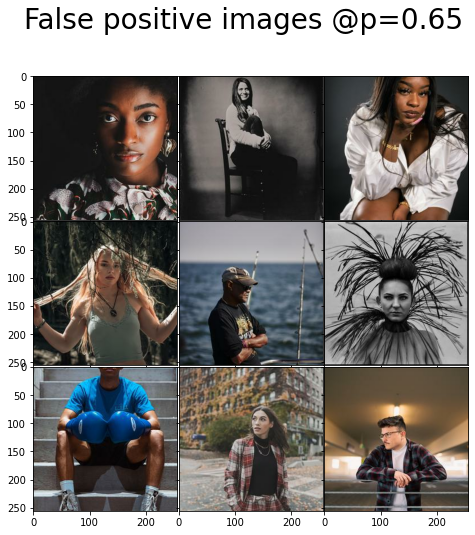

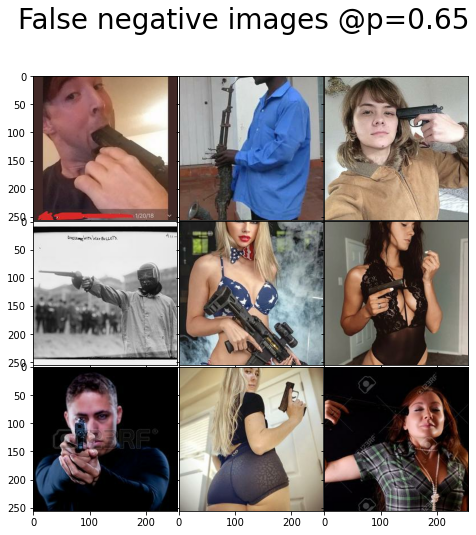

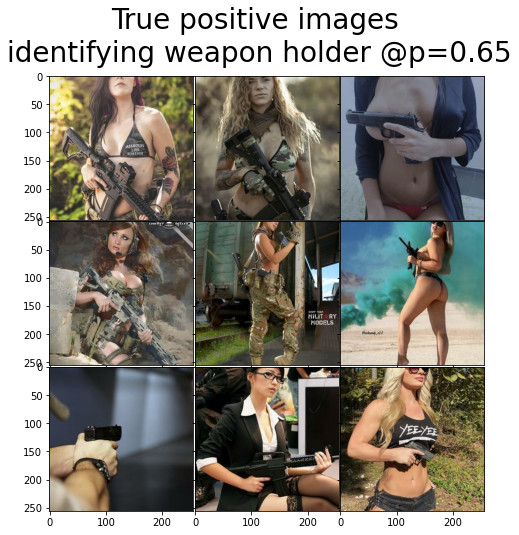

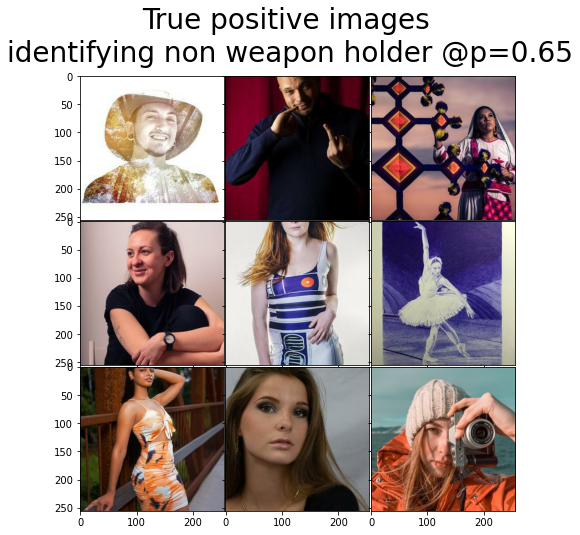

In [ ]:
show_performance(training,cnn,p=0.65)